In [1]:
# This is needed so that python finds the utils
import sys
sys.path.append("/Users/gergelyflamich/Documents/Work/MLMI/miracle-compession/code")

import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# Needed for compression as the common source of randomness
from sobol_seq import i4_sobol_generate
import numpy as np
from scipy.stats import norm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.enable_eager_execution()

tfe = tf.contrib.eager
tfs = tf.contrib.summary
tfs_logger = tfs.record_summaries_every_n_global_steps

from architectures import MnistFC_VAE, MnistFC_CNN_VAE, MnistCNN_VAE
from experiment import mnist_input_fn, mnist_binary_parse_fn
from utils import is_valid_file, setup_eager_checkpoints_and_restore

MNIST_FC_MODEL = "/tmp/miracle_mnist_bern_fc/"
MNIST_FC_CNN_MODEL = "/tmp/miracle_mnist_bern_fc_cnn/"
MNIST_CNN_MODEL = "/tmp/miracle_mnist_bern_cnn/"

MNIST_FC_CNN_GAUSS = "/tmp/miracle_mnist_gauss_fc_cnn/"


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
models = {
    "fc": MnistFC_VAE,
    "fc_cnn": MnistFC_CNN_VAE,
    "cnn": MnistCNN_VAE
}

optimizers = {
    "sgd": tf.train.GradientDescentOptimizer,
    "momentum": lambda lr:
                    tf.train.MomentumOptimizer(learning_rate=lr,
                                               momentum=0.9,
                                               use_nesterov=True),
    "adam": tf.train.AdamOptimizer,
    "rmsprop": tf.train.RMSPropOptimizer
}

config = {
        "training_set_size": 60000,
        "max_pixel_value": 1.,

        "num_latents": 40,
        "hidden_units": 300,
        "data_likelihood": "gaussian",

        "batch_size": 128,
        "num_epochs": 20,

        "loss": "neg_elbo",
        "beta": 0.03,
        "learning_rate": 1e-3,
        "optimizer": "adam",

        "log_freq": 250,
        "checkpoint_name": "_ckpt",
    }

In [3]:
num_batches = config["training_set_size"] // config["batch_size"]

((train_data, _),
(test_data, _)) = tf.keras.datasets.mnist.load_data()

train_dataset = mnist_input_fn(train_data[:num_batches * config["batch_size"]],
                               batch_size=config["batch_size"])

# ==========================================================================
# Create VAE model
# ==========================================================================

vae = models["fc_cnn"](hidden_units=config["hidden_units"],
               num_latents=config["num_latents"],
               data_likelihood=config["data_likelihood"])

# Connect the model computational graph by executing a forward-pass
vae(tf.zeros((1, 28, 28)));

# Batch norm shouldn't be fixed now
vae.training_finished()

# ==========================================================================
# Define Checkpoints
# ==========================================================================

global_step = tf.train.get_or_create_global_step()

trainable_vars = vae.get_all_variables() + (global_step,)
checkpoint_dir = os.path.join(MNIST_FC_CNN_GAUSS, "checkpoints")

checkpoint, ckpt_prefix = setup_eager_checkpoints_and_restore(
    variables=trainable_vars,
    checkpoint_dir=checkpoint_dir,
    checkpoint_name=config["checkpoint_name"])

Instructions for updating:
Colocations handled automatically by placer.
Checkpoint found at /tmp/miracle_mnist_gauss_fc_cnn/checkpoints/_ckpt-13, restoring...
Model restored!


In [23]:
bit_limit = 18

uniform_approx_samp = i4_sobol_generate(40, np.power(2, bit_limit), skip=1)
normal_approx_samp = norm.ppf(uniform_approx_samp)

train_tensor = tf.convert_to_tensor(train_data / 255., dtype=tf.float32)
test_tensor = tf.convert_to_tensor(test_data / 255., dtype=tf.float32)

In [24]:
q_mu, q_sigma = vae.encode(train_tensor[2:3, ...])

q_dist = tfd.Normal(loc=q_mu, scale=q_sigma)
p_dist = tfd.Normal(loc=tf.zeros_like(q_mu), scale=tf.ones_like(q_sigma))

total_kl = tf.reduce_sum(tfd.kl_divergence(q_dist, p_dist))

K = total_kl + (3 if total_kl < 5 else 0)

total_kl

<tf.Tensor: id=4470, shape=(), dtype=float32, numpy=44.35583>

In [25]:
posterior_log_prob = tf.reduce_sum(q_dist.log_prob(normal_approx_samp), axis=1)
prior_log_prob = tf.reduce_sum(p_dist.log_prob(normal_approx_samp), axis=1)

responsibilities = posterior_log_prob - prior_log_prob

encoding_index = tf.random.categorical(logits=responsibilities[tf.newaxis, :], num_samples=1)[0, 0]

encoding_index

<tf.Tensor: id=4511, shape=(), dtype=int64, numpy=0>

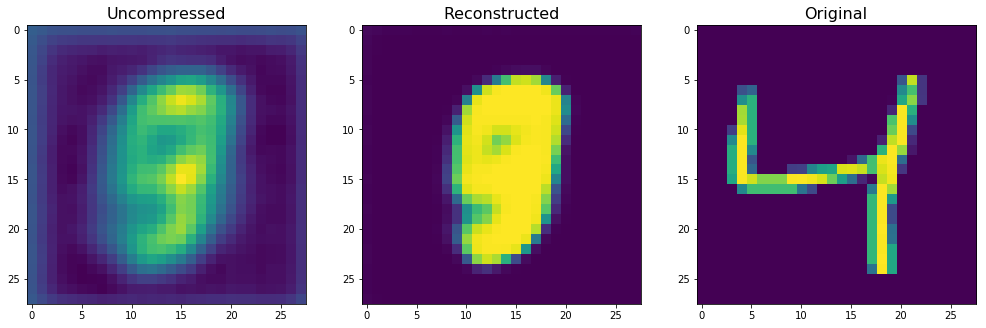

In [26]:
approx_latent = normal_approx_samp[encoding_index, :]

decoded_means = vae.decode(tf.convert_to_tensor(approx_latent[tf.newaxis, :], dtype=tf.float32))

plt.figure(figsize = (17, 6))
plt.subplot(131)
plt.title("Uncompressed", fontsize=16)
plt.imshow(decoded_means)

plt.subplot(132)
plt.title("Reconstructed", fontsize=16)
plt.imshow(vae(train_tensor[2:3, ...]))

plt.subplot(133)
plt.title("Original", fontsize=16)
plt.imshow(train_data[2])

plt.show()

In [4]:
# use 2 blocks

block_limit = 15

uniform_approx_samp_block = i4_sobol_generate(20, np.power(2, block_limit), skip=1)
normal_approx_samp_block = norm.ppf(uniform_approx_samp_block)

train_tensor = tf.convert_to_tensor(train_data / 255., dtype=tf.float32)
test_tensor = tf.convert_to_tensor(test_data / 255., dtype=tf.float32)

In [5]:
q_mu, q_sigma = vae.encode(train_tensor[:1, ...])

q_dist_block1 = tfd.Normal(loc=q_mu[:, :20], scale=q_sigma[:, :20])
p_dist_block1 = tfd.Normal(loc=tf.zeros_like(q_mu[:, :20]), scale=tf.ones_like(q_sigma[:, :20]))

q_dist_block2 = tfd.Normal(loc=q_mu[:, 20:], scale=q_sigma[:, 20:])
p_dist_block2 = tfd.Normal(loc=tf.zeros_like(q_mu[:, 20:]), scale=tf.ones_like(q_sigma[:, 20:]))

block_1_kl = tf.reduce_sum(tfd.kl_divergence(q_dist_block1, p_dist_block1))
block_2_kl = tf.reduce_sum(tfd.kl_divergence(q_dist_block2, p_dist_block2))

print("Block 1 KL: {:.2f}, Block 2 KL: {:.2f}, Total KL: {:.2f}".format(block_1_kl, 
                                                                        block_2_kl, 
                                                                        block_1_kl + block_2_kl))

posterior_log_prob_block1 = tf.reduce_sum(q_dist_block1.log_prob(normal_approx_samp_block), axis=1)
prior_log_prob_block1 = tf.reduce_sum(p_dist_block1.log_prob(normal_approx_samp_block), axis=1)

posterior_log_prob_block2 = tf.reduce_sum(q_dist_block2.log_prob(normal_approx_samp_block), axis=1)
prior_log_prob_block2 = tf.reduce_sum(p_dist_block2.log_prob(normal_approx_samp_block), axis=1)

responsibilities_block1 = posterior_log_prob_block1 - prior_log_prob_block1
responsibilities_block2 = posterior_log_prob_block2 - prior_log_prob_block2

encoding_index_block1 = tf.argmax(responsibilities_block1)
#tf.random.categorical(logits=responsibilities_block1[tf.newaxis, :], num_samples=1)[0, 0]
encoding_index_block2 = tf.argmax(responsibilities_block2)#tf.random.categorical(logits=responsibilities_block2[tf.newaxis, :], num_samples=1)[0, 0]

print(encoding_index_block1)
print(encoding_index_block2)

Block 1 KL: 23.38, Block 2 KL: 22.50, Total KL: 45.88
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


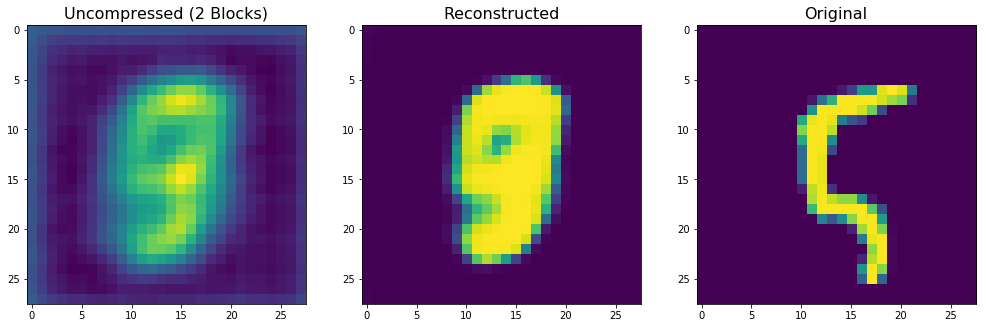

In [6]:
approx_latent_block1 = normal_approx_samp_block[encoding_index_block1, :]
approx_latent_block2 = normal_approx_samp_block[encoding_index_block2, :]

approx_latent = np.concatenate((approx_latent_block1, approx_latent_block2), axis=-1)

decoded_means = vae.decode(tf.convert_to_tensor(approx_latent[tf.newaxis, :], dtype=tf.float32))

#decoded_dist = tfd.Normal(logits=decoded_means)

plt.figure(figsize = (17, 6))
plt.subplot(131)
plt.title("Uncompressed (2 Blocks)", fontsize=16)
plt.imshow(decoded_means)

plt.subplot(132)
plt.title("Reconstructed", fontsize=16)
plt.imshow(vae(tf.convert_to_tensor(test_tensor[100][tf.newaxis, ...], dtype=tf.float32)))

plt.subplot(133)
plt.title("Original", fontsize=16)
plt.imshow(train_data[100])

plt.show()